In [1]:
import numpy as np
import matplotlib.pyplot as plt                 #For plotting
from matplotlib import cm
import matplotlib.colors as colors
import seaborn as sns;
from matplotlib.backends.backend_pdf import PdfPages       #For saving figures to single pdf
figlist = []
#*******************************************************************************************************
#Setting RC Parameters for figure size and fontsizes
import matplotlib.pylab as pylab                   
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (20, 10),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large',
         'lines.linewidth': 2.0}
pylab.rcParams.update(params)
#********************************************************************************************************
from plotting import plotTF
from noiseBudgetModule import noiseBudget
import os

In [2]:
nosbud = noiseBudget(lightInit=True)
nosbud.loadPSD('/home/controls/Git/cit_ctnlab/ctn_noisebudget/Data/SavedPSDs_20200213/SavedPSDs_20200214_125551.csv')
nosbud.PSDList['total'][2] = 'Total Expected Noise'

Creating coating stack for the noise budget...
Run stack.HongBrownianCoeffCalculations(lam) and stack.EvanThermoOpticCoeffCalculations(lam) to calculate the coefficients required for coating brownian noise and coating thermo-optic noise calculations.
Adding coatBr
Adding coatBrPh
Adding coatBrAmp
Adding coatTO
Adding coatTE
Adding coatTR
Adding subBr
Adding subTE
Adding pdhShot
Adding pllOsc
Adding pllReadout
Adding seismic
Adding photoThermal
Adding resNPRO
Adding total


In [3]:
fList = [fn for fn in os.listdir() if fn.find('Spectrum')!=-1]
for fn in fList:
    NG = int(fn.split('_')[2].replace('NG', ''))
    SG = int(fn.split('_')[3].replace('SG', '').replace('Spectrum', ''))
    nosbud.loadASD(spectrumFile = fn,
                   key = 'BeatNG'+str(NG)+'SG'+str(SG),
                   label = 'Beat NG='+str(NG)+', SG='+str(SG))
print(len(fList))

Found lower and upper bounds
Found lower and upper bounds
Found lower and upper bounds
Found lower and upper bounds
Found lower and upper bounds
Found lower and upper bounds
Found lower and upper bounds
Found lower and upper bounds
Found lower and upper bounds
Found lower and upper bounds
Found lower and upper bounds
Found lower and upper bounds
Found lower and upper bounds
Found lower and upper bounds
Found lower and upper bounds
Found lower and upper bounds
16


In [4]:
def gainValues(fn):
    NG = int(fn.split('_')[2].replace('NG', ''))
    SG = int(fn.split('_')[3].replace('SG', '').replace('Spectrum', ''))
    return {'NG' : NG,
            'SG' : SG}

In [5]:
def createBNDist(files, X, Y, fStart, fStop, y_ax, x_ax):
    Z = np.zeros(np.shape(X))
    for fn in files:
        data = np.loadtxt(fn)
        fStartInd = np.argmin(np.abs(data[:, 0] - fStart))
        fStopInd = np.argmin(np.abs(data[:, 0] - fStop))
        xG = gainValues(fn)[x_ax]
        yG = gainValues(fn)[y_ax]
        for ii in range(np.shape(Y)[0]):
            if Y[ii, 0] == yG:
                break
        for jj in range(np.shape(X)[1]):
            if X[0, jj] == xG:
                break
        #print('Ind', ii, jj)
        #print(X[ii, jj], Y[ii, jj])
        #print(yG, xG)
        Z[ii, jj] = np.sqrt(np.sum((((data[fStartInd:fStopInd, 1]**2)
                                     * (data[fStartInd+1:fStopInd+1, 0]
                                        - data[fStartInd:fStopInd, 0])
                                    ))))
    return Z

In [21]:
span_Files = [fn for fn in os.listdir() if fn.find('Spectrum')!=-1]
NG = np.array(sorted(list(set([gainValues(fn)['NG'] for fn in span_Files ]))))
SG = np.array(sorted(list(set([gainValues(fn)['SG'] for fn in span_Files ]))))
print(NG, SG)
X, Y = np.meshgrid(NG, SG)
Z = createBNDist(span_Files, X, Y, 20, 1000, 'SG', 'NG')

[ 100  200  500 1000] [ 1000  2000  5000 10000]


In [25]:
ax = sns.heatmap(Z, cmap=cm.coolwarm,
                 cbar_kws = {'label' : 'Integrated BN Noise [Hz]'},
                 linewidths=0.5, annot=True,vmin=8, vmax=12)
                 #vmin=np.min(Z[np.nonzero(Z)]), vmax = 3.2)
ax.invert_yaxis()
#ax.set_xticks(X[0, :] - X[0, 0] + 0.5)
ax.set_xticklabels(X[0, :])
plt.setp(ax.get_xticklabels(), rotation=90, ha="right",rotation_mode="anchor");
ax.set_ylim([-0.5, len(Y[:, 0]) + 0.5])
#ax.set_yticks(Y[:, 0] - Y[0, 0] + 0.5)
ax.set_yticklabels(Y[:, 0])
plt.setp(ax.get_yticklabels(), rotation=0, ha="right",
         rotation_mode="anchor");
ax.set_xlabel('NISS Gain', linespacing=4)
ax.set_ylabel('SISS Gain', linespacing=4)
ax.set_title('Beatnote frequency noise integrated from 200 Hz to 1 kHz')
fig = ax.get_figure()
fig.set_size_inches(11, 8.5, forward=True)
figlist = [fig]

In [62]:
plotList = ['total']
for key, value in nosbud.PSDList.items():
    if key.find('Beat') == 0:
        plotList += [key]

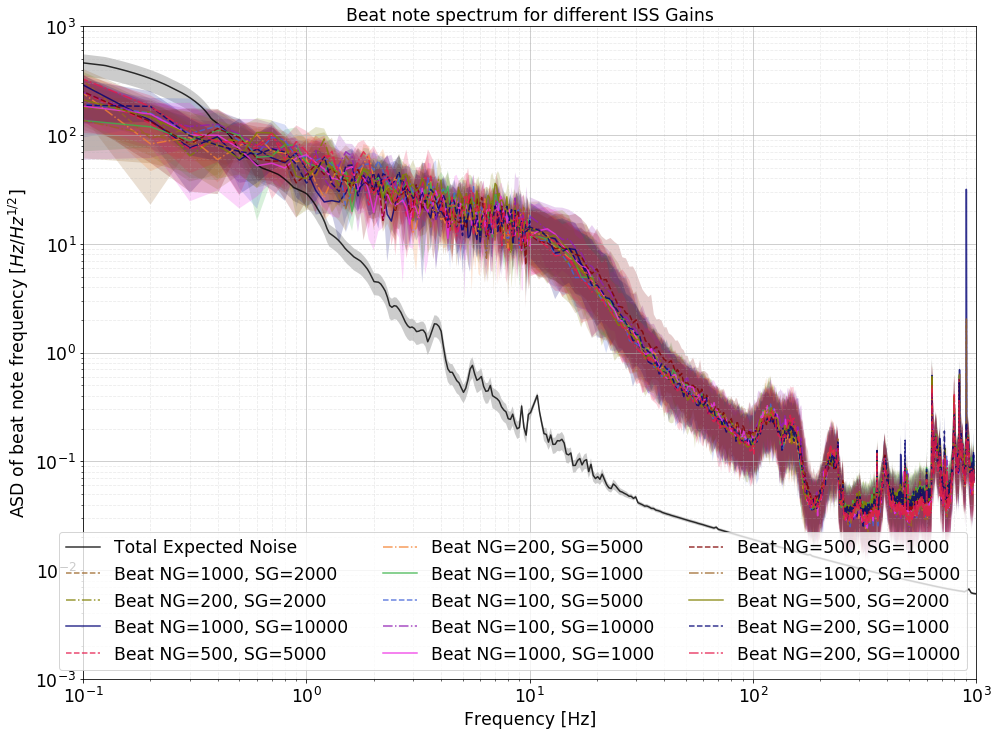

In [46]:
fig = nosbud.plotPSD(plotList=plotList,
                    title='Beat note spectrum for different ISS Gains',
                    savePlot=False,
                    doTotal=False)
ax = fig.gca()
ax.set_ylim([1e-3, 1e3])
ax.set_xlim([0.1, 1e3])
ax.legend(ncol=3)